# Import Statement

In [64]:
import warnings
warnings.filterwarnings('ignore')

import xgboost
import os
import glob
import pandas as pd
import numpy as np
import yfinance as yf
import pandas as pd
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.graphics.tsaplots import plot_acf
from plotly.subplots import make_subplots
from tqdm import tqdm

# Helper Function

In [2]:
def plot_time_series(data: pd.DataFrame, 
                    x_col: str, y_col: str, 
                    title: str, 
                    x_title: str, 
                    y_title: str, 
                    color: str = 'blue', 
                    graph_width: int = 1600, 
                    graph_height: int = 500, 
                    line_style: str = 'solid', 
                    secondary_y_col: str = None, 
                    secondary_yaxis_title: str = None,
                    drawdown_plot:bool=False) -> go.Figure:
    """
    Creates a time series plot for the given x and y data columns. Optionally, a secondary y-axis can be added
    if a secondary y-axis column is provided. The plot includes customization options for the line style, colors,
    font, background, and axis properties. 

    Parameters:
    -----------
    data : pd.DataFrame
        A pandas DataFrame containing the data to be plotted. The DataFrame must include the columns specified
        in the `x_col`, `y_col`, and optionally `secondary_y_col`.
    
    x_col : str
        The name of the column to be used for the x-axis (time series data).
    
    y_col : str
        The name of the column to be used for the primary y-axis (main data series).
    
    title : str
        The title of the chart that will be displayed at the top of the figure.
    
    x_title : str
        The title of the x-axis.
    
    y_title : str
        The title of the primary y-axis.
    
    color : str, optional
        The color for the primary line on the plot. Default is 'blue'.
    
    graph_width : int, optional
        The width of the graph in pixels. Default is 1600.
    
    graph_height : int, optional
        The height of the graph in pixels. Default is 500.
    
    line_style : str, optional
        The style of the line used to plot the data. Options include 'solid', 'dash', etc. Default is 'solid'.
    
    secondary_y_col : str, optional
        The name of the column to be used for the secondary y-axis (if applicable). If provided, a second y-axis
        will be added to the right side of the chart, and the corresponding data series will be plotted using this axis.
        Default is None, meaning no secondary y-axis will be included.

    y_axis_title : str, optional, default="Price (Rs.)"
        The title of the y-axis, representing the price of the security.
    
    x_axis_title : str, optional, default="Date"
        The title of the x-axis, representing the date or time of each data point.
    
    drawdown_plot : bool, optional, default=False
        Whether the data being passed is of drawdown or not.
    
     secondary_yaxis_title: str, optional
        The title of the secondary-y-axis. 

    Returns:
    --------
    go.Figure
        A Plotly Figure object containing the time series plot with the specified customization options.
    
    Notes:
    ------
    - The plot has a dark background color like Bloomberg with white gridlines and axis labels.
    - Font is set to "Menlo, monospace" for a clean and consistent look.
    - The x and y axes are customized with ticks, gridlines, and no mirror effect.
    - The legend is positioned horizontally below the chart, centered, with a smaller font size.
    - If a secondary y-axis is used, the secondary axis will have a border, while the primary y-axis will not.

    Example:
    --------
    fig = plot_time_series(data=df, x_col='date', y_col='price', title='Stock Price Over Time', 
                           x_title='Date', y_title='Price (USD)', secondary_y_col='volume')
    fig.show()
    """
    try:
        fig = make_subplots(specs=[[{"secondary_y": True}]])

        if drawdown_plot:
            # Plot the data as a line graph (scatter plot)
            fig.add_trace(go.Scatter(
                x=data[x_col],
                y=data[y_col],
                name=y_col,
                fill='tozeroy',
                marker=dict(color=color),
                line=dict(dash=line_style, width=2)  # Adjust line width
            ))
        else:
            # Plot the data as a line graph (scatter plot)
            fig.add_trace(go.Scatter(
                x=data[x_col],
                y=data[y_col],
                name=y_col,
                marker=dict(color=color),
                line=dict(dash=line_style, width=2)  # Adjust line width
            ))

        # If a secondary y-axis column is provided, add that trace
        if secondary_y_col:
            fig.add_trace(go.Scatter(
                x=data[x_col],
                y=data[secondary_y_col],
                name=secondary_y_col,
                marker=dict(color='orange'),  # Use a different color for the secondary axis
                line=dict(dash=line_style, width=2),
                yaxis='y2'  # Assign this trace to the secondary y-axis
            ))

        # Update the layout of the figure
        fig.update_layout(
            title=f'<b>{title}</b>',
            xaxis_title=f'<b>{x_title}</b>',
            yaxis_title=f'<b>{y_title}</b>',
            plot_bgcolor='rgb(28, 28, 28)',   # Dark background like Bloomberg
            paper_bgcolor='rgb(28, 28, 28)',  # Entire background also dark
            font=dict(family="Menlo, monospace", size=12, color='white'),  # Set Menlo font
            width=graph_width,
            height=graph_height,
            legend=dict(
                orientation='h',  # Horizontal legend
                x=0.5,  # Center the legend
                xanchor='center',
                y=-0.2,  # Position legend below the chart
                yanchor='bottom',
                font=dict(size=10, color='white')  # Regular font weight for the legend
            ),
            title_font=dict(size=20, color='white', family="Menlo, monospace"),  # Title font in Menlo
            xaxis_title_font=dict(size=12, color='white', family="Menlo, monospace"),  # X-axis title font in Menlo
            yaxis_title_font=dict(size=12, color='white', family="Menlo, monospace")  # Y-axis title font in Menlo
        )

        # Customize the x-axis with a border
        fig.update_xaxes(
            mirror=False,  # Remove mirror effect
            ticks='outside',
            showline=True,  # Show the x-axis line (border)
            gridcolor='rgb(55, 55, 55)',  # Light grey gridlines
            showgrid=True,
            tickangle=0,
            tickfont=dict(color='white', family="Menlo, monospace"),  # Set Menlo font for ticks
            zeroline=False,  # Hide zero line
            linewidth=2,  # Set thicker line for x-axis border
            linecolor='white'  # White color for the x-axis border
        )

        # Customize the primary y-axis (no border)
        fig.update_yaxes(
            mirror=False,  # Remove mirror effect
            ticks='outside',
            showline=True,  # No border for primary y-axis
            gridcolor='rgb(55, 55, 55)',  # Light grey gridlines
            showgrid=True,
            tickfont=dict(color='white', family="Menlo, monospace"),  # Set Menlo font for ticks
            zeroline=False,    # Hide zero line
            linewidth=1,       # Thicker line for grid but no axis line
            linecolor='white'  # Hide the axis line for y-axis
        )

        # Customize the secondary y-axis (border only for this axis)
        if secondary_y_col:
            fig.update_yaxes(
                secondary_y=True,  # Activate the secondary y-axis
                mirror=False,  # Remove mirror effect
                ticks='outside',
                showline=True,  # Show the line (border) for the secondary y-axis
                gridcolor='rgb(55, 55, 55)',  # Light grey gridlines
                showgrid=True,
                tickfont=dict(color='white', family="Menlo, monospace"),  # Set Menlo font for ticks
                zeroline=False,  # Hide zero line
                linewidth=2,  # Set thicker line for secondary y-axis border
                linecolor='white'  # White color for the secondary y-axis border
            )

            fig.update_yaxes(title_text=f"{secondary_yaxis_title}", secondary_y=True)

        # Adjust margins to ensure the title fits within the chart area
        fig.update_layout(
            margin=dict(l=50, r=50, t=100, b=50),  # Increase top margin to accommodate title
        )

        return fig
    except Exception as e:
        print(e)

# Load Dataset

In [3]:
no_of_companies = 16
re_download_data = False
maturities = 3
max_maturity = 10

df = pd.read_csv("CDS Dataset/cds_price_dataset.csv", index_col=0, parse_dates=True).drop([f'PX{i+1}' for i in range(maturities, max_maturity)], axis=1)
selected_company = pd.read_csv("CDS Dataset/selected_companies_data.csv")['Symbols']

# Taking only the selected companies data
df = df[df['Ticker'].isin(selected_company.to_list())]

# Data Exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27254 entries, 01-01-2015 to 10-09-2021
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ticker   27254 non-null  object 
 1   Company  27254 non-null  object 
 2   PX1      27254 non-null  float64
 3   PX2      27254 non-null  float64
 4   PX3      27254 non-null  float64
dtypes: float64(3), object(2)
memory usage: 1.2+ MB


In [5]:
df.head()

,Ticker,Company,PX1,PX2,PX3
Date,,,,,
01-01-2015,A,Agilent Technologies Inc,14.850,25.05,39.055
02-01-2015,A,Agilent Technologies Inc,14.855,25.15,39.160
05-01-2015,A,Agilent Technologies Inc,13.455,24.96,39.310
06-01-2015,A,Agilent Technologies Inc,15.535,24.88,39.300
07-01-2015,A,Agilent Technologies Inc,15.215,25.50,40.270


In [6]:
df['Ticker'].nunique(), df.shape

(16, (27254, 5))

In [7]:
df.describe()

,PX1,PX2,PX3
count,27254.000000,27254.000000,27254.000000
mean,12.301800,19.698162,29.975937
std,9.014952,12.719507,17.266884
min,2.510000,3.390000,5.050000
25%,7.355325,12.031550,18.385000
50%,9.875000,17.482500,27.090000
75%,14.503750,23.563750,37.369825
max,142.714000,208.462600,253.953700


# Including - Fundamental Data and Price Data

In [8]:
# If we want to store the processed that.
save_data = True

if re_download_data:
    for ticker in tqdm(df['Ticker'].unique()):
        # Process the fundamental data
        fd_data = pd.read_excel(os.path.join("Fundamental_Data", f"{ticker}.xlsx"), skiprows=10).T
        fd_data.columns = fd_data.iloc[0]
        fd_data = fd_data.iloc[1:].dropna(how="all", axis=1).dropna(how="all")

        fd_data = fd_data.reset_index()
        fd_data = fd_data.rename(columns={"index":"Period End Date", "Field Name":"Date"})
        fd_data.columns.name = None
        fd_data = fd_data.set_index('Date')
        fd_data = fd_data.drop("Period End Date", axis=1)
        fd_data.index = pd.to_datetime(fd_data.index, dayfirst=True)
        fd_data = fd_data.astype('float64').sort_index().loc["2015":]


        # price data
        price_data = yf.download(ticker, start='2015-01-01', end='2021-12-31', progress=False, auto_adjust=True)
        price_data.columns = price_data.columns.droplevel(level=1)
        price_data.columns.name = None
        price_data['Ticker'] = ticker
        
        # combined dataset using FD, Price and Spread Data
        new_data = df.merge(price_data, on=['Date', 'Ticker'], how='left').dropna().merge(fd_data, on='Date', how='left').ffill().dropna()

        if save_data:
            new_data.to_csv(f"Final Datasets/{ticker}.csv")

# Data Cleaning

In [9]:
total_df = pd.DataFrame()

for stocks in glob.glob("Final Datasets/*.csv"):

    stock = stocks.split("\\")[-1].split(".csv")[0]
    if stock in selected_company.to_list():
        data = pd.read_csv(stocks, index_col=0)
        total_df = pd.concat([total_df, data])

In [10]:
# sorted the data by date and tickers

total_df = total_df.sort_values(['Date', 'Ticker'])
total_df.index = pd.to_datetime(total_df.index)

In [11]:
# Download the VIX and 10 year CBOE Treasury Rate
vix_data = yf.download("^VIX", start="2015-01-01", end="2021-12-31", progress=False, auto_adjust=True)
vix_data.columns = vix_data.columns.droplevel(level=1)
vix_data.columns.name = None
vix_data['Ticker'] = "VIX"
vix_data = vix_data.rename(columns={"Close":"VIX"})


rf = yf.download("^TNX", start="2015-01-01", end="2021-12-31", progress=False, auto_adjust=True)
rf.columns = rf.columns.droplevel(level=1)
rf.columns.name = None
rf['Ticker'] = "10-Year U.S. Treasury Note"
rf = rf.rename(columns={"Close":"10YrTNO"})

broad_index = yf.download("^GSPC", start="2015-01-01", end="2021-12-31", progress=False, auto_adjust=True)
broad_index.columns = broad_index.columns.droplevel(level=1)
broad_index.columns.name = None
broad_index['Ticker'] = "S&P500"
broad_index = broad_index.rename(columns={"Close":"SP500"})

combined_macro_data = vix_data[['VIX']].merge(rf[['10YrTNO']], on="Date", how="left").merge(broad_index[['SP500']], on="Date", how="left")

In [12]:
# loading LIBOR data
libor_rates = pd.read_csv("LIBOR/libor_without12M.csv", index_col=0, parse_dates=True).sort_index()
combined_macro_data = combined_macro_data.merge(libor_rates, on="Date", how="left")

In [13]:
# select those columns which are present against all tickers
common_cols = {}
for stocks in glob.glob("Final Datasets/*.csv"):

    stock = stocks.split("\\")[-1].split(".csv")[0]
    if stock in selected_company.to_list():
        data = pd.read_csv(stocks, index_col=0)

        for key in list(data.columns):
            if key in common_cols.keys():
                common_cols[key] += 1
            else:
                common_cols[key] = 1

cols_to_keep = [key for key, val in common_cols.items() if val == no_of_companies]

In [14]:
# filtered out those columns which are present in all tickers
total_df = total_df[cols_to_keep]
total_df = total_df.merge(combined_macro_data, on="Date", how="left")
total_df = total_df.ffill()
total_df.columns = pd.Series(total_df.columns).apply(lambda x: x.split('.1')[0] if x.endswith('.1') else x)
total_df = total_df.loc[:, ~total_df.columns.duplicated()]
total_df = total_df.drop([f'PX{i+1}' for i in range(maturities, max_maturity)], axis=1)

In [15]:
# final cleaned dataset
total_df.tail()

,Ticker,Company,PX1,PX2,PX3,Close,High,Low,Open,Volume,...,Total Debt Percentage of Total Capital,Total Debt Percentage of Total Equity,Earnings Retention Rate,Dividend Payout Ratio - %,VIX,10YrTNO,SP500,USD_LIBOR1M,USD_LIBOR3M,USD_LIBOR6M
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-10,BWA,BorgWarner Inc,12.8974,20.8810,30.9152,36.006237,36.291865,35.737406,36.039839,1650040.0,...,38.31,62.10,0.83,16.60,20.950001,1.341,4458.580078,0.08388,0.11575,0.14938
2021-09-10,COF,Capital One Financial Corp,12.1811,21.8047,32.1758,145.520233,147.634383,145.370556,146.783111,2855400.0,...,35.99,56.24,0.95,5.28,20.950001,1.341,4458.580078,0.08388,0.11575,0.14938
2021-09-10,CVS,CVS Health Corp,9.2980,13.8536,21.3120,74.799484,76.602739,74.415622,76.593817,6454400.0,...,48.12,92.75,0.63,36.78,20.950001,1.341,4458.580078,0.08388,0.11575,0.14938
2021-09-10,NKE,NIKE Inc,4.9820,8.5384,14.3680,156.809143,158.793348,156.665366,157.441789,4252100.0,...,39.67,65.75,0.77,23.21,20.950001,1.341,4458.580078,0.08388,0.11575,0.14938
2021-09-10,SCHW,The Charles Schwab Corp,11.6279,19.9437,30.6807,68.082451,69.550075,68.025266,69.550075,4099900.0,...,27.88,38.66,0.69,30.62,20.950001,1.341,4458.580078,0.08388,0.11575,0.14938


In [16]:
total_df.shape

(13526, 36)

# Data Exploration

In [17]:
def filer_company(data:pd.DataFrame, ticker:str) -> pd.DataFrame:
    return data[data['Ticker']==ticker]

In [18]:
# sector definitions
healthcare = ['ABT','AMGN', 'A', 'BDX', 'BMY', 'CVS', 'ABBV', 'BSX']
financials = ['ALL', 'AIG', 'COF', 'SCHW', 'AXP']
CD = ['NKE', 'AMZN', 'BWA']

We will replace the `Volume` and `Revenue from Business Activities - Total` with - `Volume Change` and `Revenue Growth` information when modelling, because these are absolute numbers - does not provide much information.

In [19]:
total_df['Ticker'].unique()

array(['ABT', 'ALL', 'AMGN', 'A', 'NKE', 'AMZN', 'COF', 'BDX', 'AIG',
       'BMY', 'CVS', 'ABBV', 'BWA', 'BSX', 'SCHW', 'AXP'], dtype=object)

In [20]:
total_df.columns

Index(['Ticker', 'Company', 'PX1', 'PX2', 'PX3', 'Close', 'High', 'Low',
       'Open', 'Volume', 'Revenue from Business Activities - Total',
       'Operating Profit before Non-Recurring Income/Expense',
       'Income before Discontinued Operations & Extraordinary Items',
       'Total Assets', 'Common Equity - Total',
       'Net Cash Flow from Operating Activities',
       'Depreciation, Depletion & Amortization including Impairment - Cash Flow - to Reconcile',
       'Capital Expenditures - Net - Cash Flow', 'Net Change in Cash - Total',
       'EPS - Diluted - excluding Extraordinary Items Applicable to Common - Total',
       'Shares used to calculate Diluted EPS - Total',
       'Income before Tax Margin - %', 'Income Tax Rate - %', 'Net Margin - %',
       'Common Shares - Outstanding - Total',
       'Total Debt Percentage of Total Assets',
       'Total Debt Percentage of Total Capital',
       'Total Debt Percentage of Total Equity', 'Earnings Retention Rate',
       'Divid

In [21]:
total_df['Industry'] = np.nan

for row in range(len(total_df)):
    if total_df.iloc[row, 0] in healthcare:
        total_df.iloc[row, -1] = "Healthcare"
    elif total_df.iloc[row, 0] in financials:
        total_df.iloc[row, -1] = "Financials"
    elif total_df.iloc[row, 0] in CD:
        total_df.iloc[row, -1] = "Consumer Discretionary"

### PX1 Correlation 

In [22]:
healthcare_companies = total_df[total_df['Industry']=="Healthcare"]
healthcare_corr_px1 = {}

for health in tqdm(healthcare_companies['Ticker'].unique()):
    healthcare_corr_px1[health] = {}
    for cols in healthcare_companies.columns:
        if cols not in ['PX1', 'PX2', 'PX3', 'Ticker', 'Company', 'Industry']:
            healthcare_corr_px1[health][f'PX1_{cols}'] = healthcare_companies.loc[healthcare_companies['Ticker']==health, cols].corr(healthcare_companies.loc[healthcare_companies['Ticker']==health, "PX1"])


financial_companies = total_df[total_df['Industry']=="Financials"]
financial_corr_px1 = {}

for fin in tqdm(financial_companies['Ticker'].unique()):
    financial_corr_px1[fin] = {}
    for cols in financial_companies.columns:
        if cols not in ['PX1', 'PX2', 'PX3', 'Ticker', 'Company', 'Industry']:
            financial_corr_px1[fin][f'PX1_{cols}'] = financial_companies.loc[financial_companies['Ticker']==fin, cols].corr(financial_companies.loc[financial_companies['Ticker']==fin, "PX1"])


consd_companies = total_df[total_df['Industry']=="Consumer Discretionary"]
consd_corr_px1 = {}

for con in tqdm(consd_companies['Ticker'].unique()):
    consd_corr_px1[con] = {}
    for cols in consd_companies.columns:
        if cols not in ['PX1', 'PX2', 'PX3', 'Ticker', 'Company', 'Industry']:
            consd_corr_px1[con][f'PX1_{cols}'] = consd_companies.loc[consd_companies['Ticker']==con, cols].corr(consd_companies.loc[consd_companies['Ticker']==con, "PX1"])

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 21.80it/s]


### PX2 Correlation Analysis

In [23]:
healthcare_companies = total_df[total_df['Industry']=="Healthcare"]
healthcare_corr_px2 = {}

for health in tqdm(healthcare_companies['Ticker'].unique()):
    healthcare_corr_px2[health] = {}
    for cols in healthcare_companies.columns:
        if cols not in ['PX1', 'PX2', 'PX3', 'Ticker', 'Company', 'Industry']:
            healthcare_corr_px2[health][f'PX2_{cols}'] = healthcare_companies.loc[healthcare_companies['Ticker']==health, cols].corr(healthcare_companies.loc[healthcare_companies['Ticker']==health, "PX2"])


financial_companies = total_df[total_df['Industry']=="Financials"]
financial_corr_px2 = {}

for fin in tqdm(financial_companies['Ticker'].unique()):
    financial_corr_px2[fin] = {}
    for cols in financial_companies.columns:
        if cols not in ['PX1', 'PX2', 'PX3', 'Ticker', 'Company', 'Industry']:
            financial_corr_px2[fin][f'PX2_{cols}'] = financial_companies.loc[financial_companies['Ticker']==fin, cols].corr(financial_companies.loc[financial_companies['Ticker']==fin, "PX2"])


consd_companies = total_df[total_df['Industry']=="Consumer Discretionary"]
consd_corr_px2 = {}

for con in tqdm(consd_companies['Ticker'].unique()):
    consd_corr_px2[con] = {}
    for cols in consd_companies.columns:
        if cols not in ['PX1', 'PX2', 'PX3', 'Ticker', 'Company', 'Industry']:
            consd_corr_px2[con][f'PX2_{cols}'] = consd_companies.loc[consd_companies['Ticker']==con, cols].corr(consd_companies.loc[consd_companies['Ticker']==con, "PX2"])

100%|██████████| 3/3 [00:00<00:00, 22.45it/s]


### PX3 Correlation Analysis

In [24]:
healthcare_companies = total_df[total_df['Industry']=="Healthcare"]
healthcare_corr_px3 = {}

for health in tqdm(healthcare_companies['Ticker'].unique()):
    healthcare_corr_px3[health] = {}
    for cols in healthcare_companies.columns:
        if cols not in ['PX1', 'PX2', 'PX3', 'Ticker', 'Company', 'Industry']:
            healthcare_corr_px3[health][f'PX3_{cols}'] = healthcare_companies.loc[healthcare_companies['Ticker']==health, cols].corr(healthcare_companies.loc[healthcare_companies['Ticker']==health, "PX3"])


financial_companies = total_df[total_df['Industry']=="Financials"]
financial_corr_px3 = {}

for fin in tqdm(financial_companies['Ticker'].unique()):
    financial_corr_px3[fin] = {}
    for cols in financial_companies.columns:
        if cols not in ['PX1', 'PX2', 'PX3', 'Ticker', 'Company', 'Industry']:
            financial_corr_px3[fin][f'PX3_{cols}'] = financial_companies.loc[financial_companies['Ticker']==fin, cols].corr(financial_companies.loc[financial_companies['Ticker']==fin, "PX3"])


consd_companies = total_df[total_df['Industry']=="Consumer Discretionary"]
consd_corr_px3 = {}

for con in tqdm(consd_companies['Ticker'].unique()):
    consd_corr_px3[con] = {}
    for cols in consd_companies.columns:
        if cols not in ['PX1', 'PX2', 'PX3', 'Ticker', 'Company', 'Industry']:
            consd_corr_px3[con][f'PX3_{cols}'] = consd_companies.loc[consd_companies['Ticker']==con, cols].corr(consd_companies.loc[consd_companies['Ticker']==con, "PX3"])

100%|██████████| 3/3 [00:00<00:00, 21.04it/s]


### Details to Include in Mid-Semester Detailed Work Section

-	The actual work, the method of treatment and the results are presented in this part of a report. It may run into many sections and subsections under different headings and subheadings.
-	Give detailed description of project based on the work completed so far
-	Include suitable diagrams, data/information tables, charts, etc. as necessary
-	Inferences/conclusions should emanate from the results of data analysis/study
-	Recommendations should be related to the objectives
-	Implementation strategy, if applicable, should include approvals required from the management, human resources and physical resources required, financial resources required and expected monthly/quarterly expenditure plan, suggested organization/project structure required to implement the recommendations, implementation schedule-Gantt chart/timelines.
-	The extent of contents for this section depends on the extent to which the project has been completed and benefits realized at the time of mid-semester project report submission.


For Work-related project:
-	Give functional and/or technical details, as applicable
-	Explain the deliverables
-	Analysis of data collected
-	Inferences / Conclusions
-	Recommendations
-	Implementation strategy to implement the recommendations

For Industry-related project:
-	Explain the diagnosis done viz literature study, primary data study, secondary data study, etc.
-	Tools/Methods used for data analysis like Porters Five Forces, BCG Matrix, Porters Competitive Strategy, etc., as applicable
-	Analysis of data collected
-	Inferences / Conclusions
-	Recommendations in terms of framework, future outlook, etc.
-	Implementation strategy to implement the recommendations

For Academic project:
-	Literature review
-	Source of primary and secondary data, data collection methods, ethics in data collection, etc.
-	Secondary data analysis, if any
-	Research gaps
-	Research questions
-	Data set preparation, Data analysis
-	Hypothesized model implementation


### Visual Analysis 

Effect of Financial Distress - VIX

In [25]:
covid_analysis = total_df[(total_df['Ticker'].isin(['NKE', 'ABT', 'ALL'])) & ((total_df.index > '2019.01.01') & (total_df.index < '2020.06.30'))]

for uni_tick in covid_analysis['Ticker'].unique():
    dt = covid_analysis[covid_analysis['Ticker']==uni_tick]
    plot_time_series(data=dt.reset_index(), x_col="Date", y_col="PX1", title=f"1 Year Spread vs VIX (COVID Phase) - {dt['Industry'].unique()[0]} ({dt['Ticker'].unique()[0]})", y_title="CDS 1 Year Spread", 
                    x_title="Date", secondary_y_col="VIX", secondary_yaxis_title="VIX").show()

Effect of Financial Distress - Treasury Rates

In [26]:
covid_analysis = total_df[(total_df['Ticker'].isin(['NKE', 'ABT', 'ALL'])) & ((total_df.index > '2019.01.01') & (total_df.index < '2020.06.30'))]

for uni_tick in covid_analysis['Ticker'].unique():
    dt = covid_analysis[covid_analysis['Ticker']==uni_tick]
    plot_time_series(data=dt.reset_index(), x_col="Date", y_col="PX1", title=f"1 Year Spread vs 10 Year Treasury (COVID Phase) - {dt['Industry'].unique()[0]} ({dt['Ticker'].unique()[0]})", y_title="CDS 1 Year Spread", 
                    x_title="Date", secondary_y_col="10YrTNO", secondary_yaxis_title="10 Year Treasury Note").show()

Effect of Auto-Correlation

<Figure size 1000x600 with 0 Axes>

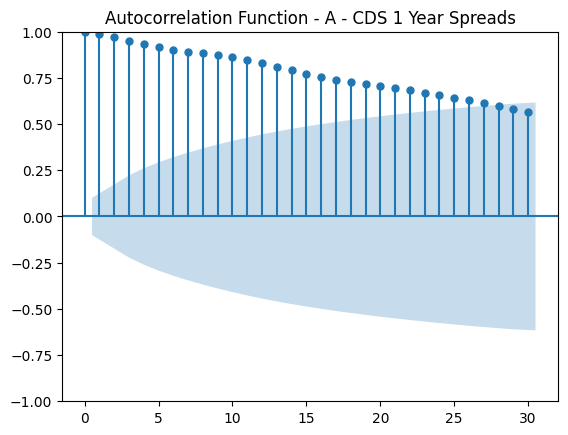

<Figure size 1000x600 with 0 Axes>

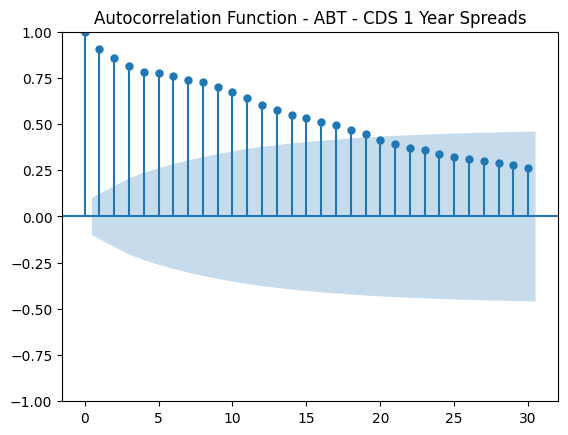

<Figure size 1000x600 with 0 Axes>

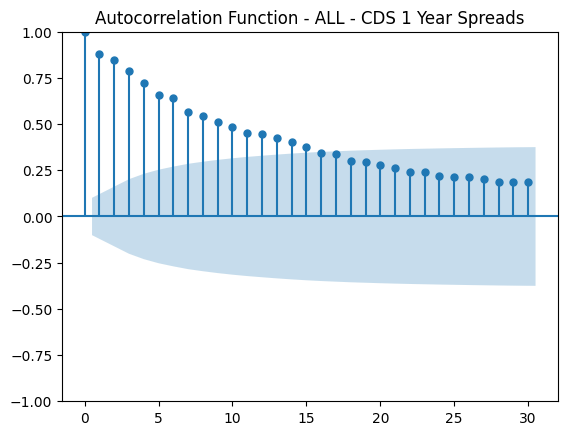

<Figure size 1000x600 with 0 Axes>

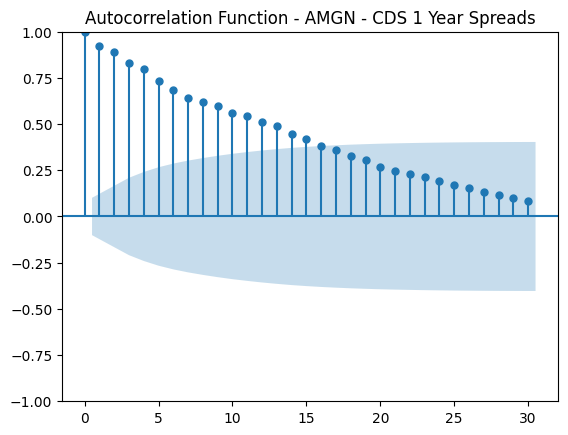

<Figure size 1000x600 with 0 Axes>

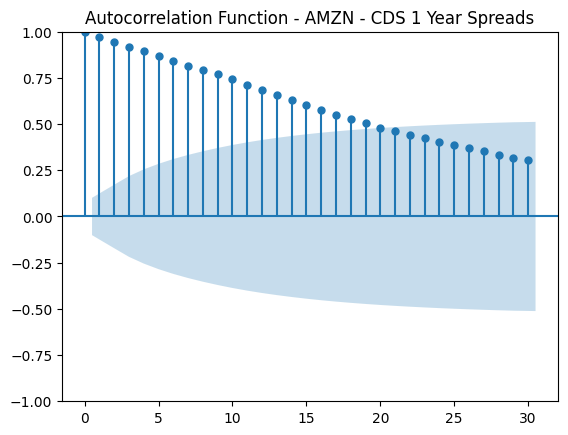

<Figure size 1000x600 with 0 Axes>

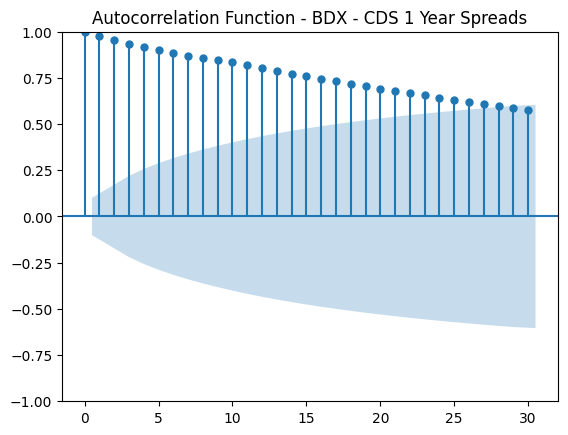

<Figure size 1000x600 with 0 Axes>

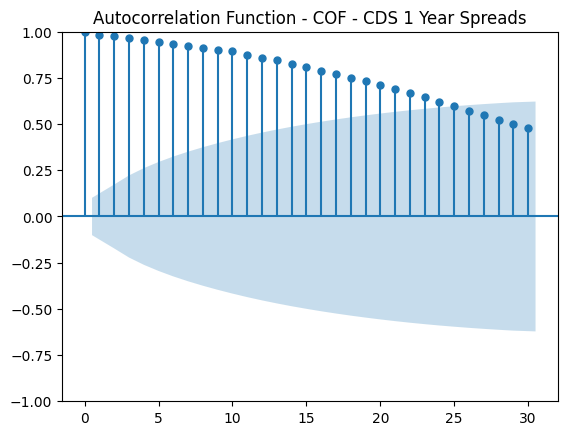

<Figure size 1000x600 with 0 Axes>

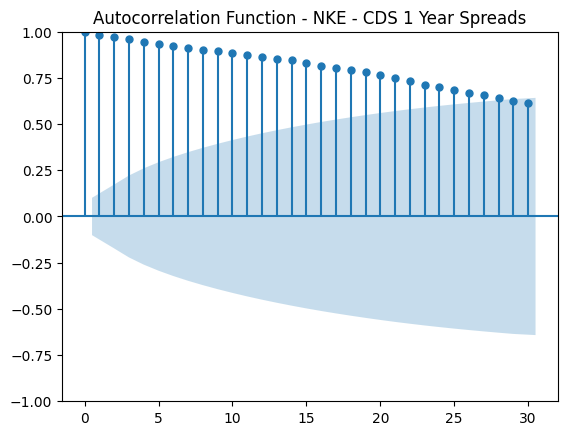

<Figure size 1000x600 with 0 Axes>

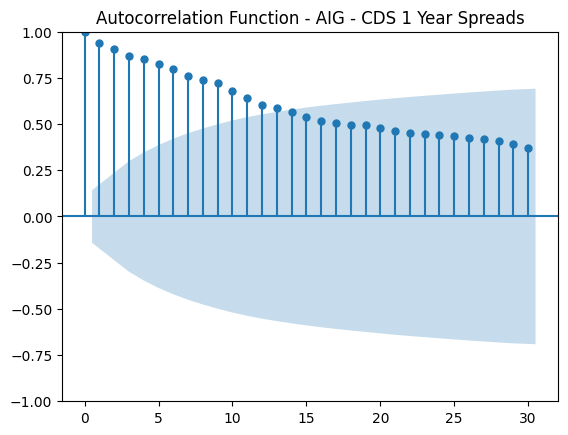

<Figure size 1000x600 with 0 Axes>

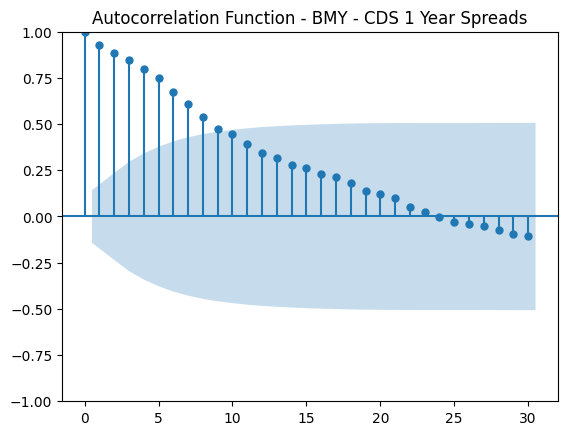

<Figure size 1000x600 with 0 Axes>

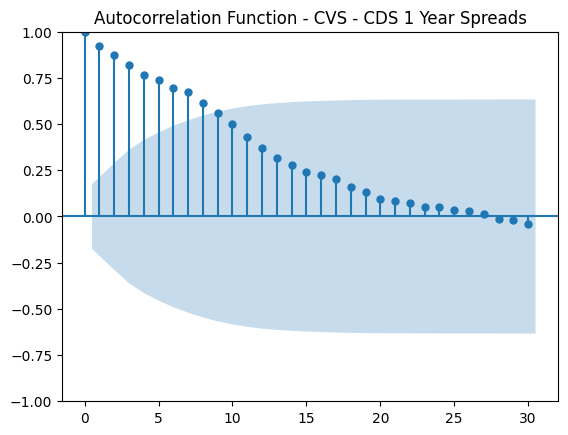

In [27]:
covid_analysis = total_df[((total_df.index > '2019.01.01') & (total_df.index < '2020.06.30'))]

for uni_tick in covid_analysis['Ticker'].unique():
    dt = covid_analysis[covid_analysis['Ticker']==uni_tick]
    
    # Plot the autocorrelation function
    plt.figure(figsize=(10, 6))
    plot_acf(dt['PX1'], lags=30)  # You can adjust the number of lags as needed
    plt.title(f'Autocorrelation Function - {dt["Ticker"].unique()[0]} - CDS 1 Year Spreads')
    plt.show()

Overall - Market Relationship

In [28]:
covid_analysis = total_df[(total_df.index > '2019.01.01') & (total_df.index < '2020.06.30')]

for uni_tick in covid_analysis['Ticker'].unique():
    dt = covid_analysis[covid_analysis['Ticker']==uni_tick]
    plot_time_series(data=dt.reset_index(), x_col="Date", y_col="PX2", title=f"CDS Spread vs S&P500 - {dt['Industry'].unique()[0]} ({dt['Ticker'].unique()[0]})", y_title="CDS 2 Year Spread", 
                    x_title="Date", secondary_y_col="SP500", secondary_yaxis_title="S&P500").show()

Fundamental Data

In [29]:
corr_matrix = pd.DataFrame(healthcare_corr_px1).T.iloc[:, 5:-6]
corr_matrix.columns = pd.Series(corr_matrix.columns).apply(lambda x: " ".join(x.split(" ")[:4])).to_list()

fig = px.imshow(corr_matrix.round(2), text_auto=True)

# Update layout to apply Bloomberg-like dark theme
fig.update_layout(
    title=f"Healthcare Companies PX1 Relationship with Fundamentals",
    yaxis_title="<b>Company</b>",
    xaxis_title="<b>Fundamental Data</b>",
    title_font=dict(size=20, color='white', family="Menlo, monospace"),
    plot_bgcolor='rgb(28, 28, 28)',  # Dark background
    paper_bgcolor='rgb(28, 28, 28)',  # Entire background dark
    font=dict(family='Menlo, monospace', size=12, color='white'),
    height=500,
    width=1600,
)

# Update x and y axes with Bloomberg-style dark theme
fig.update_xaxes(
    mirror=False,  # No mirror effect for x-axis
    ticks='outside',
    showline=True,
    linecolor='white',  # White line for x-axis
    gridcolor='rgb(55, 55, 55)',  # Light grey gridlines for x-axis
    tickfont=dict(color='white', family="Menlo, monospace"),
    zeroline=False,  # Hide zero line
    linewidth=2,
)

fig.update_yaxes(
    mirror=False,  # No mirror effect for y-axis
    ticks='outside',
    showline=True,
    linecolor='white',  # White line for y-axis
    gridcolor='rgb(55, 55, 55)',  # Light grey gridlines for y-axis
    tickfont=dict(color='white', family="Menlo, monospace"),
    zeroline=False,  # Hide zero line
    linewidth=2,
)

fig.show()

In [30]:
criteria = corr_matrix[abs(corr_matrix) > 0.25].isna().sum()
abs(abs(corr_matrix[abs(corr_matrix) > 0.25].loc[:, criteria <= 3]).mean()).sort_values(ascending=False)

Series([], dtype: float64)

In [31]:
corr_matrix = pd.DataFrame(healthcare_corr_px2).T.iloc[:, 5:-6]
corr_matrix.columns = pd.Series(corr_matrix.columns).apply(lambda x: " ".join(x.split(" ")[:4])).to_list()

fig = px.imshow(corr_matrix.round(2), text_auto=True)

# Update layout to apply Bloomberg-like dark theme
fig.update_layout(
    title=f"Healthcare Companies PX2 Relationship with Fundamentals",
    yaxis_title="<b>Company</b>",
    xaxis_title="<b>Fundamental Data</b>",
    title_font=dict(size=20, color='white', family="Menlo, monospace"),
    plot_bgcolor='rgb(28, 28, 28)',  # Dark background
    paper_bgcolor='rgb(28, 28, 28)',  # Entire background dark
    font=dict(family='Menlo, monospace', size=12, color='white'),
    height=500,
    width=1600,
)

# Update x and y axes with Bloomberg-style dark theme
fig.update_xaxes(
    mirror=False,  # No mirror effect for x-axis
    ticks='outside',
    showline=True,
    linecolor='white',  # White line for x-axis
    gridcolor='rgb(55, 55, 55)',  # Light grey gridlines for x-axis
    tickfont=dict(color='white', family="Menlo, monospace"),
    zeroline=False,  # Hide zero line
    linewidth=2,
)

fig.update_yaxes(
    mirror=False,  # No mirror effect for y-axis
    ticks='outside',
    showline=True,
    linecolor='white',  # White line for y-axis
    gridcolor='rgb(55, 55, 55)',  # Light grey gridlines for y-axis
    tickfont=dict(color='white', family="Menlo, monospace"),
    zeroline=False,  # Hide zero line
    linewidth=2,
)

fig.show()

In [32]:
criteria = corr_matrix[abs(corr_matrix) > 0.25].isna().sum()
abs(abs(corr_matrix[abs(corr_matrix) > 0.25].loc[:, criteria <= 3]).mean()).sort_values(ascending=False)

PX2_Depreciation, Depletion & Amortization    0.560967
PX2_Common Shares - Outstanding               0.528349
PX2_Total Debt Percentage of                  0.513140
PX2_Capital Expenditures - Net                0.490311
PX2_Total Debt Percentage of                  0.472906
PX2_Net Change in Cash                        0.471677
PX2_Income before Tax Margin                  0.469658
PX2_Net Margin - %                            0.468510
PX2_Common Equity - Total                     0.468437
PX2_Shares used to calculate                  0.465235
PX2_Total Debt Percentage of                  0.465167
PX2_Revenue from Business Activities          0.447259
PX2_Total Assets                              0.428495
dtype: float64

In [33]:
corr_matrix = pd.DataFrame(healthcare_corr_px3).T.iloc[:, 5:-6]
corr_matrix.columns = pd.Series(corr_matrix.columns).apply(lambda x: " ".join(x.split(" ")[:4])).to_list()

fig = px.imshow(corr_matrix.round(2), text_auto=True)

# Update layout to apply Bloomberg-like dark theme
fig.update_layout(
    title=f"Healthcare Companies PX3 Relationship with Fundamentals",
    yaxis_title="<b>Company</b>",
    xaxis_title="<b>Fundamental Data</b>",
    title_font=dict(size=20, color='white', family="Menlo, monospace"),
    plot_bgcolor='rgb(28, 28, 28)',  # Dark background
    paper_bgcolor='rgb(28, 28, 28)',  # Entire background dark
    font=dict(family='Menlo, monospace', size=12, color='white'),
    height=500,
    width=1600,
)

# Update x and y axes with Bloomberg-style dark theme
fig.update_xaxes(
    mirror=False,  # No mirror effect for x-axis
    ticks='outside',
    showline=True,
    linecolor='white',  # White line for x-axis
    gridcolor='rgb(55, 55, 55)',  # Light grey gridlines for x-axis
    tickfont=dict(color='white', family="Menlo, monospace"),
    zeroline=False,  # Hide zero line
    linewidth=2,
)

fig.update_yaxes(
    mirror=False,  # No mirror effect for y-axis
    ticks='outside',
    showline=True,
    linecolor='white',  # White line for y-axis
    gridcolor='rgb(55, 55, 55)',  # Light grey gridlines for y-axis
    tickfont=dict(color='white', family="Menlo, monospace"),
    zeroline=False,  # Hide zero line
    linewidth=2,
)

fig.show()

In [34]:
criteria = corr_matrix[abs(corr_matrix) > 0.25].isna().sum()
abs(abs(corr_matrix[abs(corr_matrix) > 0.25].loc[:, criteria <= 3]).mean()).sort_values(ascending=False)

PX3_Net Change in Cash                        0.518142
PX3_Depreciation, Depletion & Amortization    0.512568
PX3_Common Shares - Outstanding               0.496580
PX3_Capital Expenditures - Net                0.495003
PX3_Income before Tax Margin                  0.477666
PX3_EPS - Diluted -                           0.462854
PX3_Income before Discontinued Operations     0.461131
PX3_Net Margin - %                            0.436315
PX3_Shares used to calculate                  0.435301
dtype: float64

#### PX1 Plot for All Companies

In [35]:
fig = go.Figure()

for comp in total_df['Ticker'].unique():
    tmp_data = total_df[total_df['Ticker']==comp]
    fig.add_trace(
        go.Scatter(
            x = tmp_data.index,
            y = tmp_data.PX3,
            name = f"{comp}"
        )
    )

fig.update_layout(plot_bgcolor="white", xaxis_title="Date", yaxis_title="PX3", title="PX3 Trends - All Companies", font=dict(family="Cascadia code, courier new, monspace", size=12))

# Feature Engg.

In [36]:
# Drop Open, High, Low and Keep only Close, as they are very highly correlated.
total_df = total_df.drop(['Open', 'High', 'Low', 'Shares used to calculate Diluted EPS - Total'], axis=1)

In [37]:
final_df = pd.DataFrame()

for tick in total_df['Ticker'].unique():

    data = total_df[total_df['Ticker']==tick]

    # Changes in Crucial Levels
    data['Stock_Return'] = data['Close'].pct_change()
    data['Index_Return'] = data['SP500'].pct_change()
    data['Volume_Change'] = data['Volume'] - data['Volume'].rolling(15).median()

    # Lagged Features
    data['PX1_Lagged_1'] = data['PX1'].shift(1)
    data['PX1_Lagged_2'] = data['PX1'].shift(2)
    data['PX1_Lagged_3'] = data['PX1'].shift(3)

    data['PX2_Lagged_1'] = data['PX2'].shift(1)
    data['PX2_Lagged_2'] = data['PX2'].shift(2)
    data['PX2_Lagged_3'] = data['PX2'].shift(3)

    data['PX3_Lagged_1'] = data['PX3'].shift(1)
    data['PX3_Lagged_2'] = data['PX3'].shift(2)
    data['PX3_Lagged_3'] = data['PX3'].shift(3)

    # Rolling Volatility
    data['Volatility'] = data['Close'].pct_change().rolling(15).std() * np.sqrt(252)

    # Moving Averages
    data['SMA_5_10_Close'] = data['Close'].rolling(5).mean() - data['Close'].rolling(10).mean()
    data['SMA_5_10_SP500'] = data['SP500'].rolling(5).mean() - data['SP500'].rolling(10).mean()

    # Fundamental Data Features
    data['Revenue_Change'] = data['Revenue from Business Activities - Total'].pct_change()
    data['Operating_Profit_Change'] = data['Operating Profit before Non-Recurring Income/Expense'].pct_change()
    data['Income_Before_Dis_Change'] = data['Income before Discontinued Operations & Extraordinary Items'].pct_change()
    data['Change_in_Total_Assets'] = data['Total Assets'].pct_change()
    data['Change_in_Common_Equity'] = data['Common Equity - Total'].pct_change()
    data['Change_in_Net_Cash_Flow'] = data['Net Cash Flow from Operating Activities'].pct_change()

    data = data.drop(['Revenue from Business Activities - Total', 'Operating Profit before Non-Recurring Income/Expense', 'Volume',
                      'Income before Discontinued Operations & Extraordinary Items', 'Total Assets', 'Common Equity - Total', 'Net Cash Flow from Operating Activities'], axis=1)

    # Encoding the categorical features
    data['Industry'] = data['Industry'].apply(lambda x: 1 if x == "Healthcare" else(2 if x == "Financials" else 3))

    # Label Calculation
    data['Label_1yr'] = data['PX1'].shift(-1)
    data['Label_2yr'] = data['PX2'].shift(-1)
    data['Label_3yr'] = data['PX3'].shift(-1)

    final_df = pd.concat([final_df, data])

In [38]:
final_df.head()

,Ticker,Company,PX1,PX2,PX3,Close,"Depreciation, Depletion & Amortization including Impairment - Cash Flow - to Reconcile",Capital Expenditures - Net - Cash Flow,Net Change in Cash - Total,EPS - Diluted - excluding Extraordinary Items Applicable to Common - Total,...,SMA_5_10_SP500,Revenue_Change,Operating_Profit_Change,Income_Before_Dis_Change,Change_in_Total_Assets,Change_in_Common_Equity,Change_in_Net_Cash_Flow,Label_1yr,Label_2yr,Label_3yr
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-31,ABT,Abbott Laboratories,4.890,6.905,12.025,38.292355,371.0,235.0,-837.0,0.35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.935,6.915,12.025
2015-04-01,ABT,Abbott Laboratories,4.935,6.915,12.025,37.928661,371.0,235.0,-837.0,0.35,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,5.050,7.400,12.795
2015-04-02,ABT,Abbott Laboratories,5.050,7.400,12.795,38.127045,371.0,235.0,-837.0,0.35,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,4.870,6.850,11.970
2015-04-06,ABT,Abbott Laboratories,4.870,6.850,11.970,38.267548,371.0,235.0,-837.0,0.35,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,4.965,7.010,12.085
2015-04-07,ABT,Abbott Laboratories,4.965,7.010,12.085,38.176624,371.0,235.0,-837.0,0.35,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,4.915,6.915,12.025


# Feature / Label Split

In [39]:
final_df = final_df.sort_index().dropna()
features = final_df.drop(['Ticker', 'Company', 'PX1', 'PX2', 'PX3', 'Label_1yr', 'Label_2yr', 'Label_3yr'], axis=1)
label_1_yr = final_df['Label_1yr']
label_2_yr = final_df['Label_2yr']
label_3_yr = final_df['Label_3yr']

## Train Test Split

In [40]:
train_features = features.loc['2015':'2020']
test_features = features.loc['2021':]

train_label_one = label_1_yr.loc['2015':'2020']
test_label_one = label_1_yr.loc['2021':]

train_label_two = label_2_yr.loc['2015':'2020']
test_label_two = label_2_yr.loc['2021':]

train_label_three = label_3_yr.loc['2015':'2020']
test_label_three = label_3_yr.loc['2021':]

In [41]:
train_features.shape, test_features.shape

((10804, 42), (2466, 42))

# Modelling

### One Year Maturity - Model

In [42]:
# Model Training
linear_one_yr_mat = LinearRegression()
linear_one_yr_mat.fit(train_features, train_label_one)

rf_one_yr_mat = RandomForestRegressor()
rf_one_yr_mat.fit(train_features, train_label_one)

xg_one_yr_mat = xgboost.XGBRegressor()
xg_one_yr_mat.fit(train_features, train_label_one)


# Predictions
one_year_mat_linear = linear_one_yr_mat.predict(test_features)
one_year_mat_rf = rf_one_yr_mat.predict(test_features)
one_year_mat_xg = xg_one_yr_mat.predict(test_features)

In [43]:
one_yr_mat_models = pd.DataFrame({"Date": test_label_one.index.to_list(), "RandomForest Predictions": one_year_mat_rf, "LinearRegression Predicitions": one_year_mat_linear, "XGBoost": one_year_mat_xg, 
                                                    "Actual": test_label_one.values, 'Company': final_df.loc['2021':, 'Ticker'].values})

In [44]:
print("MAPE of Random Forest Model - One Year Maturity: ", round(mean_absolute_percentage_error(one_yr_mat_models['Actual'], one_yr_mat_models['RandomForest Predictions']), 2))
print("MAPE of Linear Regression Model - One Year Maturity: ", round(mean_absolute_percentage_error(one_yr_mat_models['Actual'], one_yr_mat_models['LinearRegression Predicitions']), 2))
print("MAPE of XGBoost Model - One Year Maturity: ",round(mean_absolute_percentage_error(one_yr_mat_models['Actual'], one_yr_mat_models['XGBoost']), 2))

print("MAE of Random Forest Model - One Year Maturity: ", round(mean_absolute_error(one_yr_mat_models['Actual'], one_yr_mat_models['RandomForest Predictions']), 2))
print("MAE of Linear Regression Model - One Year Maturity: ", round(mean_absolute_error(one_yr_mat_models['Actual'], one_yr_mat_models['LinearRegression Predicitions']), 2))
print("MAE of XGBoost Model - One Year Maturity: ", round(mean_absolute_error(one_yr_mat_models['Actual'], one_yr_mat_models['XGBoost']), 2))

print("RMSE of Random Forest Model - One Year Maturity: ", round(np.sqrt(mean_squared_error(one_yr_mat_models['Actual'], one_yr_mat_models['RandomForest Predictions'])), 2))
print("RMSE of Linear Regression Model - One Year Maturity: ", round(np.sqrt(mean_squared_error(one_yr_mat_models['Actual'], one_yr_mat_models['LinearRegression Predicitions'])), 2))
print("RMSE of XGBoost Model - One Year Maturity: ", round(np.sqrt(mean_squared_error(one_yr_mat_models['Actual'], one_yr_mat_models['XGBoost'])), 2))

MAPE of Random Forest Model - One Year Maturity:  0.07
MAPE of Linear Regression Model - One Year Maturity:  0.06
MAPE of XGBoost Model - One Year Maturity:  0.1
MAE of Random Forest Model - One Year Maturity:  1.0
MAE of Linear Regression Model - One Year Maturity:  0.81
MAE of XGBoost Model - One Year Maturity:  1.44
RMSE of Random Forest Model - One Year Maturity:  2.18
RMSE of Linear Regression Model - One Year Maturity:  1.74
RMSE of XGBoost Model - One Year Maturity:  2.67


### Two Year Maturity - Model

In [45]:
# Model Training
linear_two_yr_mat = LinearRegression()
linear_two_yr_mat.fit(train_features, train_label_two)

rf_two_yr_mat = RandomForestRegressor()
rf_two_yr_mat.fit(train_features, train_label_two)

xg_two_yr_mat = xgboost.XGBRegressor()
xg_two_yr_mat.fit(train_features, train_label_two)


# Predictions
two_year_mat_linear = linear_two_yr_mat.predict(test_features)
two_year_mat_rf = rf_two_yr_mat.predict(test_features)
two_year_mat_xg = xg_two_yr_mat.predict(test_features)

In [46]:
two_yr_mat_models = pd.DataFrame({"Date": test_label_two.index.to_list(), "RandomForest Predictions": two_year_mat_rf, "LinearRegression Predicitions": two_year_mat_linear, "XGBoost": two_year_mat_xg, 
                                                    "Actual": test_label_two.values, 'Company': final_df.loc['2021':, 'Ticker'].values})

In [47]:
print("MAPE of Random Forest Model - Two Year Maturity: ", round(mean_absolute_percentage_error(two_yr_mat_models['Actual'], two_yr_mat_models['RandomForest Predictions']), 2))
print("MAPE of Linear Regression Model - Two Year Maturity: ", round(mean_absolute_percentage_error(two_yr_mat_models['Actual'], two_yr_mat_models['LinearRegression Predicitions']), 2))
print("MAPE of XGBoost Model - Two Year Maturity: ",round(mean_absolute_percentage_error(two_yr_mat_models['Actual'], two_yr_mat_models['XGBoost']), 2))

print("MAE of Random Forest Model - Two Year Maturity: ", round(mean_absolute_error(two_yr_mat_models['Actual'], two_yr_mat_models['RandomForest Predictions']), 2))
print("MAE of Linear Regression Model - Two Year Maturity: ", round(mean_absolute_error(two_yr_mat_models['Actual'], two_yr_mat_models['LinearRegression Predicitions']), 2))
print("MAE of XGBoost Model - Two Year Maturity: ", round(mean_absolute_error(two_yr_mat_models['Actual'], two_yr_mat_models['XGBoost']), 2))

print("RMSE of Random Forest Model - Two Year Maturity: ", round(np.sqrt(mean_squared_error(two_yr_mat_models['Actual'], two_yr_mat_models['RandomForest Predictions'])), 2))
print("RMSE of Linear Regression Model - Two Year Maturity: ", round(np.sqrt(mean_squared_error(two_yr_mat_models['Actual'], two_yr_mat_models['LinearRegression Predicitions'])), 2))
print("RMSE of XGBoost Model - Two Year Maturity: ", round(np.sqrt(mean_squared_error(two_yr_mat_models['Actual'], two_yr_mat_models['XGBoost'])), 2))

MAPE of Random Forest Model - Two Year Maturity:  0.07
MAPE of Linear Regression Model - Two Year Maturity:  0.05
MAPE of XGBoost Model - Two Year Maturity:  0.09
MAE of Random Forest Model - Two Year Maturity:  1.34
MAE of Linear Regression Model - Two Year Maturity:  0.98
MAE of XGBoost Model - Two Year Maturity:  1.81
RMSE of Random Forest Model - Two Year Maturity:  2.5
RMSE of Linear Regression Model - Two Year Maturity:  2.12
RMSE of XGBoost Model - Two Year Maturity:  3.09


### Three Year Maturity Models

In [48]:
# Model Training
linear_three_yr_mat = LinearRegression()
linear_three_yr_mat.fit(train_features, train_label_three)

rf_three_yr_mat = RandomForestRegressor()
rf_three_yr_mat.fit(train_features, train_label_three)

xg_three_yr_mat = xgboost.XGBRegressor()
xg_three_yr_mat.fit(train_features, train_label_three)


# Predictions
three_year_mat_linear = linear_three_yr_mat.predict(test_features)
three_year_mat_rf = rf_three_yr_mat.predict(test_features)
three_year_mat_xg = xg_three_yr_mat.predict(test_features)

In [49]:
three_yr_mat_models = pd.DataFrame({"Date": test_label_three.index.to_list(), "RandomForest Predictions": three_year_mat_rf, "LinearRegression Predicitions": three_year_mat_linear, "XGBoost": three_year_mat_xg, 
                                                    "Actual": test_label_three.values, 'Company': final_df.loc['2021':, 'Ticker'].values})

In [50]:
print("MAPE of Random Forest Model - Three Year Maturity: ", round(mean_absolute_percentage_error(three_yr_mat_models['Actual'], three_yr_mat_models['RandomForest Predictions']), 2))
print("MAPE of Linear Regression Model - Three Year Maturity: ", round(mean_absolute_percentage_error(three_yr_mat_models['Actual'], three_yr_mat_models['LinearRegression Predicitions']), 2))
print("MAPE of XGBoost Model - Three Year Maturity: ",round(mean_absolute_percentage_error(three_yr_mat_models['Actual'], three_yr_mat_models['XGBoost']), 2))

print("MAE of Random Forest Model - Three Year Maturity: ", round(mean_absolute_error(three_yr_mat_models['Actual'], three_yr_mat_models['RandomForest Predictions']), 2))
print("MAE of Linear Regression Model - Three Year Maturity: ", round(mean_absolute_error(three_yr_mat_models['Actual'], three_yr_mat_models['LinearRegression Predicitions']), 2))
print("MAE of XGBoost Model - Three Year Maturity: ", round(mean_absolute_error(three_yr_mat_models['Actual'], three_yr_mat_models['XGBoost']), 2))

print("RMSE of Random Forest Model - Three Year Maturity: ", round(np.sqrt(mean_squared_error(three_yr_mat_models['Actual'], three_yr_mat_models['RandomForest Predictions'])), 2))
print("RMSE of Linear Regression Model - Three Year Maturity: ", round(np.sqrt(mean_squared_error(three_yr_mat_models['Actual'], three_yr_mat_models['LinearRegression Predicitions'])), 2))
print("RMSE of XGBoost Model - Three Year Maturity: ", round(np.sqrt(mean_squared_error(three_yr_mat_models['Actual'], three_yr_mat_models['XGBoost'])), 2))

MAPE of Random Forest Model - Three Year Maturity:  0.05
MAPE of Linear Regression Model - Three Year Maturity:  0.04
MAPE of XGBoost Model - Three Year Maturity:  0.08
MAE of Random Forest Model - Three Year Maturity:  1.45
MAE of Linear Regression Model - Three Year Maturity:  1.22
MAE of XGBoost Model - Three Year Maturity:  2.11
RMSE of Random Forest Model - Three Year Maturity:  2.93
RMSE of Linear Regression Model - Three Year Maturity:  2.61
RMSE of XGBoost Model - Three Year Maturity:  3.31


# Hyperparameter Tuning

## One Year Maturity

In [51]:
# Define the model
rf_one_yr_mat = RandomForestRegressor()

# Define the hyperparameters distribution
param_dist_rf = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Perform RandomizedSearchCV
random_search_rf = RandomizedSearchCV(estimator=rf_one_yr_mat, param_distributions=param_dist_rf, n_iter=100, cv=5, verbose=2, n_jobs=-1, scoring='neg_mean_squared_error')
random_search_rf.fit(train_features, train_label_one)

# Best parameters and best score
print("Best parameters:", random_search_rf.best_params_)
print("Best score:", random_search_rf.best_score_)

# Refit the model with the best parameters
best_rf_model = random_search_rf.best_estimator_

# Predictions with best model
one_year_mat_rf_best = best_rf_model.predict(test_features)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}
Best score: -3.9832002613481974


In [52]:
# Define the model
xg_one_yr_mat = xgboost.XGBRegressor()

# Define the hyperparameters distribution
param_dist_xg = {
    'n_estimators': np.arange(100, 1001, 100),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'alpha': [0, 0.1, 1],
    'lambda': [0, 1]
}

# Perform RandomizedSearchCV
random_search_xg = RandomizedSearchCV(estimator=xg_one_yr_mat, param_distributions=param_dist_xg, n_iter=100, cv=5, verbose=2, n_jobs=-1, scoring='neg_mean_squared_error')
random_search_xg.fit(train_features, train_label_one)

# Best parameters and best score
print("Best parameters:", random_search_xg.best_params_)
print("Best score:", random_search_xg.best_score_)

# Refit the model with the best parameters
best_xg_model = random_search_xg.best_estimator_

# Predictions with best model
one_year_mat_xg_best = best_xg_model.predict(test_features)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 700, 'max_depth': 9, 'learning_rate': 0.1, 'lambda': 1, 'gamma': 0, 'colsample_bytree': 1.0, 'alpha': 1}
Best score: -11.820881975729066


In [55]:
one_yr_mat_models_opt = pd.DataFrame({"Date": test_label_one.index.to_list(), "RandomForest Predictions": one_year_mat_rf_best, "LinearRegression Predicitions": one_year_mat_linear, "XGBoost": one_year_mat_xg_best, 
                                                    "Actual": test_label_one.values, 'Company': final_df.loc['2021':, 'Ticker'].values})

In [57]:
print("MAPE of Random Forest Model - One Year Maturity: ", round(mean_absolute_percentage_error(one_yr_mat_models_opt['Actual'], one_yr_mat_models_opt['RandomForest Predictions']), 2))
print("MAPE of Linear Regression Model - One Year Maturity: ", round(mean_absolute_percentage_error(one_yr_mat_models_opt['Actual'], one_yr_mat_models_opt['LinearRegression Predicitions']), 2))
print("MAPE of XGBoost Model - One Year Maturity: ",round(mean_absolute_percentage_error(one_yr_mat_models_opt['Actual'], one_yr_mat_models_opt['XGBoost']), 2))

print("MAE of Random Forest Model - One Year Maturity: ", round(mean_absolute_error(one_yr_mat_models_opt['Actual'], one_yr_mat_models_opt['RandomForest Predictions']), 2))
print("MAE of Linear Regression Model - One Year Maturity: ", round(mean_absolute_error(one_yr_mat_models_opt['Actual'], one_yr_mat_models_opt['LinearRegression Predicitions']), 2))
print("MAE of XGBoost Model - One Year Maturity: ", round(mean_absolute_error(one_yr_mat_models_opt['Actual'], one_yr_mat_models_opt['XGBoost']), 2))

print("RMSE of Random Forest Model - One Year Maturity: ", round(np.sqrt(mean_squared_error(one_yr_mat_models_opt['Actual'], one_yr_mat_models_opt['RandomForest Predictions'])), 2))
print("RMSE of Linear Regression Model - One Year Maturity: ", round(np.sqrt(mean_squared_error(one_yr_mat_models_opt['Actual'], one_yr_mat_models_opt['LinearRegression Predicitions'])), 2))
print("RMSE of XGBoost Model - One Year Maturity: ", round(np.sqrt(mean_squared_error(one_yr_mat_models_opt['Actual'], one_yr_mat_models_opt['XGBoost'])), 2))

MAPE of Random Forest Model - One Year Maturity:  0.07
MAPE of Linear Regression Model - One Year Maturity:  0.06
MAPE of XGBoost Model - One Year Maturity:  0.08
MAE of Random Forest Model - One Year Maturity:  1.07
MAE of Linear Regression Model - One Year Maturity:  0.81
MAE of XGBoost Model - One Year Maturity:  1.29
RMSE of Random Forest Model - One Year Maturity:  2.22
RMSE of Linear Regression Model - One Year Maturity:  1.74
RMSE of XGBoost Model - One Year Maturity:  2.76


## Two Year Maturity Model

In [52]:
# Define the model
rf_two_yr_mat = RandomForestRegressor()

# Define the hyperparameters distribution
param_dist_rf = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Perform RandomizedSearchCV
random_search_rf = RandomizedSearchCV(estimator=rf_two_yr_mat, param_distributions=param_dist_rf, n_iter=100, cv=5, verbose=2, n_jobs=-1, scoring='neg_mean_squared_error')
random_search_rf.fit(train_features, train_label_two)

# Best parameters and best score
print("Best parameters:", random_search_rf.best_params_)
print("Best score:", random_search_rf.best_score_)

# Refit the model with the best parameters
best_rf_model = random_search_rf.best_estimator_

# Predictions with best model
two_year_mat_rf_best = best_rf_model.predict(test_features)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 40, 'bootstrap': True}
Best score: -10.89479011876247


In [53]:
# Define the model
xg_two_yr_mat = xgboost.XGBRegressor()

# Define the hyperparameters distribution
param_dist_xg = {
    'n_estimators': np.arange(100, 1001, 100),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'alpha': [0, 0.1, 1],
    'lambda': [0, 1]
}

# Perform RandomizedSearchCV
random_search_xg = RandomizedSearchCV(estimator=xg_two_yr_mat, param_distributions=param_dist_xg, n_iter=100, cv=5, verbose=2, n_jobs=-1, scoring='neg_mean_squared_error')
random_search_xg.fit(train_features, train_label_two)

# Best parameters and best score
print("Best parameters:", random_search_xg.best_params_)
print("Best score:", random_search_xg.best_score_)

# Refit the model with the best parameters
best_xg_model = random_search_xg.best_estimator_

# Predictions with best model
two_year_mat_xg_best = best_xg_model.predict(test_features)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1, 'lambda': 1, 'gamma': 1, 'colsample_bytree': 1.0, 'alpha': 1}
Best score: -14.983181337239534


In [54]:
two_yr_mat_models_opt = pd.DataFrame({"Date": test_label_two.index.to_list(), "RandomForest Predictions": two_year_mat_rf_best, "LinearRegression Predicitions": two_year_mat_linear, "XGBoost": two_year_mat_xg_best, 
                                                    "Actual": test_label_two.values, 'Company': final_df.loc['2021':, 'Ticker'].values})

In [55]:
print("MAPE of Random Forest Model - two Year Maturity: ", round(mean_absolute_percentage_error(two_yr_mat_models_opt['Actual'], two_yr_mat_models_opt['RandomForest Predictions']), 2))
print("MAPE of Linear Regression Model - two Year Maturity: ", round(mean_absolute_percentage_error(two_yr_mat_models_opt['Actual'], two_yr_mat_models_opt['LinearRegression Predicitions']), 2))
print("MAPE of XGBoost Model - two Year Maturity: ",round(mean_absolute_percentage_error(two_yr_mat_models_opt['Actual'], two_yr_mat_models_opt['XGBoost']), 2))

print("MAE of Random Forest Model - two Year Maturity: ", round(mean_absolute_error(two_yr_mat_models_opt['Actual'], two_yr_mat_models_opt['RandomForest Predictions']), 2))
print("MAE of Linear Regression Model - two Year Maturity: ", round(mean_absolute_error(two_yr_mat_models_opt['Actual'], two_yr_mat_models_opt['LinearRegression Predicitions']), 2))
print("MAE of XGBoost Model - two Year Maturity: ", round(mean_absolute_error(two_yr_mat_models_opt['Actual'], two_yr_mat_models_opt['XGBoost']), 2))

print("RMSE of Random Forest Model - two Year Maturity: ", round(np.sqrt(mean_squared_error(two_yr_mat_models_opt['Actual'], two_yr_mat_models_opt['RandomForest Predictions'])), 2))
print("RMSE of Linear Regression Model - two Year Maturity: ", round(np.sqrt(mean_squared_error(two_yr_mat_models_opt['Actual'], two_yr_mat_models_opt['LinearRegression Predicitions'])), 2))
print("RMSE of XGBoost Model - two Year Maturity: ", round(np.sqrt(mean_squared_error(two_yr_mat_models_opt['Actual'], two_yr_mat_models_opt['XGBoost'])), 2))

MAPE of Random Forest Model - two Year Maturity:  0.05
MAPE of Linear Regression Model - two Year Maturity:  0.05
MAPE of XGBoost Model - two Year Maturity:  0.08
MAE of Random Forest Model - two Year Maturity:  1.0
MAE of Linear Regression Model - two Year Maturity:  0.98
MAE of XGBoost Model - two Year Maturity:  1.67
RMSE of Random Forest Model - two Year Maturity:  2.3
RMSE of Linear Regression Model - two Year Maturity:  2.12
RMSE of XGBoost Model - two Year Maturity:  2.79


## Three Year Maturity Model

In [56]:
# Define the model
rf_three_yr_mat = RandomForestRegressor()

# Define the hyperparameters distribution
param_dist_rf = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Perform RandomizedSearchCV
random_search_rf = RandomizedSearchCV(estimator=rf_three_yr_mat, param_distributions=param_dist_rf, n_iter=100, cv=5, verbose=2, n_jobs=-1, scoring='neg_mean_squared_error')
random_search_rf.fit(train_features, train_label_three)

# Best parameters and best score
print("Best parameters:", random_search_rf.best_params_)
print("Best score:", random_search_rf.best_score_)

# Refit the model with the best parameters
best_rf_model = random_search_rf.best_estimator_

# Predictions with best model
three_year_mat_rf_best = best_rf_model.predict(test_features)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
Best score: -27.495723147755065


In [57]:
# Define the model
xg_three_yr_mat = xgboost.XGBRegressor()

# Define the hyperparameters distribution
param_dist_xg = {
    'n_estimators': np.arange(100, 1001, 100),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'alpha': [0, 0.1, 1],
    'lambda': [0, 1]
}

# Perform RandomizedSearchCV
random_search_xg = RandomizedSearchCV(estimator=xg_three_yr_mat, param_distributions=param_dist_xg, n_iter=100, cv=5, verbose=2, n_jobs=-1, scoring='neg_mean_squared_error')
random_search_xg.fit(train_features, train_label_three)

# Best parameters and best score
print("Best parameters:", random_search_xg.best_params_)
print("Best score:", random_search_xg.best_score_)

# Refit the model with the best parameters
best_xg_model = random_search_xg.best_estimator_

# Predictions with best model
three_year_mat_xg_best = best_xg_model.predict(test_features)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.1, 'lambda': 1, 'gamma': 0, 'colsample_bytree': 1.0, 'alpha': 1}
Best score: -24.981818812373014


In [58]:
three_yr_mat_models_opt = pd.DataFrame({"Date": test_label_three.index.to_list(), "RandomForest Predictions": three_year_mat_rf_best, "LinearRegression Predicitions": three_year_mat_linear, "XGBoost": three_year_mat_xg_best, 
                                                    "Actual": test_label_three.values, 'Company': final_df.loc['2021':, 'Ticker'].values})

In [59]:
print("MAPE of Random Forest Model - three Year Maturity: ", round(mean_absolute_percentage_error(three_yr_mat_models_opt['Actual'], three_yr_mat_models_opt['RandomForest Predictions']), 2))
print("MAPE of Linear Regression Model - three Year Maturity: ", round(mean_absolute_percentage_error(three_yr_mat_models_opt['Actual'], three_yr_mat_models_opt['LinearRegression Predicitions']), 2))
print("MAPE of XGBoost Model - three Year Maturity: ",round(mean_absolute_percentage_error(three_yr_mat_models_opt['Actual'], three_yr_mat_models_opt['XGBoost']), 2))

print("MAE of Random Forest Model - three Year Maturity: ", round(mean_absolute_error(three_yr_mat_models_opt['Actual'], three_yr_mat_models_opt['RandomForest Predictions']), 2))
print("MAE of Linear Regression Model - three Year Maturity: ", round(mean_absolute_error(three_yr_mat_models_opt['Actual'], three_yr_mat_models_opt['LinearRegression Predicitions']), 2))
print("MAE of XGBoost Model - three Year Maturity: ", round(mean_absolute_error(three_yr_mat_models_opt['Actual'], three_yr_mat_models_opt['XGBoost']), 2))

print("RMSE of Random Forest Model - three Year Maturity: ", round(np.sqrt(mean_squared_error(three_yr_mat_models_opt['Actual'], three_yr_mat_models_opt['RandomForest Predictions'])), 2))
print("RMSE of Linear Regression Model - three Year Maturity: ", round(np.sqrt(mean_squared_error(three_yr_mat_models_opt['Actual'], three_yr_mat_models_opt['LinearRegression Predicitions'])), 2))
print("RMSE of XGBoost Model - three Year Maturity: ", round(np.sqrt(mean_squared_error(three_yr_mat_models_opt['Actual'], three_yr_mat_models_opt['XGBoost'])), 2))

MAPE of Random Forest Model - three Year Maturity:  0.05
MAPE of Linear Regression Model - three Year Maturity:  0.04
MAPE of XGBoost Model - three Year Maturity:  0.06
MAE of Random Forest Model - three Year Maturity:  1.66
MAE of Linear Regression Model - three Year Maturity:  1.22
MAE of XGBoost Model - three Year Maturity:  1.88
RMSE of Random Forest Model - three Year Maturity:  3.47
RMSE of Linear Regression Model - three Year Maturity:  2.61
RMSE of XGBoost Model - three Year Maturity:  3.35


In [85]:
# print("Three year Linear Regression Model r2-score", round(r2_score(three_yr_mat_models_opt['Actual'], three_yr_mat_models_opt['LinearRegression Predicitions']), 2))
# print("Three year RandomForest Model r2-score", round(r2_score(three_yr_mat_models_opt['Actual'], three_yr_mat_models_opt['RandomForest Predictions']), 2))
# print("Three year XGBoost Model r2-score", round(r2_score(three_yr_mat_models_opt['Actual'], three_yr_mat_models_opt['XGBoost']), 2))

# print("two year Linear Regression Model r2-score", round(r2_score(two_yr_mat_models_opt['Actual'], two_yr_mat_models_opt['LinearRegression Predicitions']), 2))
# print("two year RandomForest Model r2-score", round(r2_score(two_yr_mat_models_opt['Actual'], two_yr_mat_models_opt['RandomForest Predictions']), 2))
# print("two year XGBoost Model r2-score", round(r2_score(two_yr_mat_models_opt['Actual'], two_yr_mat_models_opt['XGBoost']), 2))

# print("one year Linear Regression Model r2-score", 0.95)
# print("one year RandomForest Model r2-score", 0.96)
# print("one year XGBoost Model r2-score", 0.95)

# Gantt Chart

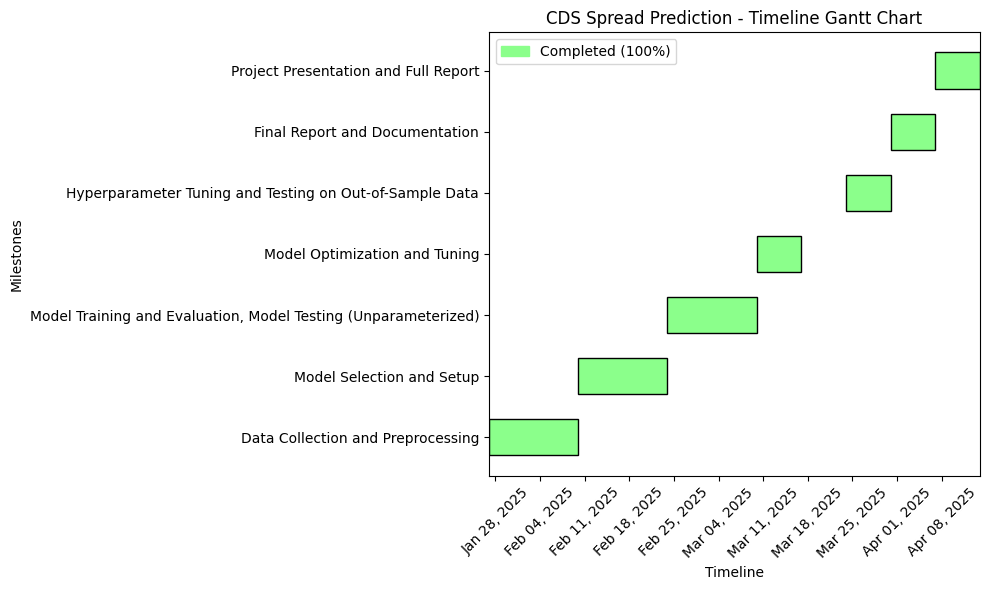

In [63]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches

# Define the milestones and dates
milestones = [
    "Data Collection and Preprocessing",
    "Model Selection and Setup",
    "Model Training and Evaluation, Model Testing (Unparameterized)",
    "Model Optimization and Tuning",
    "Hyperparameter Tuning and Testing on Out-of-Sample Data",
    "Final Report and Documentation",
    "Project Presentation and Full Report"
]

# Define the start and end dates for each milestone
start_dates = pd.to_datetime([
    "2025-01-27", "2025-02-10", "2025-02-24", "2025-03-10", "2025-03-24", "2025-03-31", "2025-04-07"
])

end_dates = pd.to_datetime([
    "2025-02-10", "2025-02-24", "2025-03-10", "2025-03-17", "2025-03-31", "2025-04-07", "2025-04-14"
])

# Set progress percentage for each milestone
# Based on the final status (all tasks are complete except for presentation and final report)
progress = [100, 100, 100, 100, 100, 100, 100]

# Define colors for the Gantt chart (based on progress)
colors = ['#8bff8b', '#8bff8b', '#8bff8b', '#8bff8b', '#8bff8b', '#8bff8b', '#8bff8b']
# Colors correspond to: green (100% done), red (not started)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each milestone as a horizontal bar with respective progress
for i, (start, end, prog, color) in enumerate(zip(start_dates, end_dates, progress, colors)):
    ax.barh(milestones[i], (end - start).days, left=start, color=color, edgecolor='black', height=0.6)

# Set x-axis to show date range
ax.set_xlim(pd.to_datetime("2025-01-27"), pd.to_datetime("2025-04-14"))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))
plt.xticks(rotation=45)

# Set labels and title
ax.set_xlabel('Timeline')
ax.set_ylabel('Milestones')
ax.set_title('CDS Spread Prediction - Timeline Gantt Chart')

# Add a legend for progress representation
legend_labels = [
    mpatches.Patch(color='#8bff8b', label="Completed (100%)"),
    # mpatches.Patch(color='#ff4d4d', label="Yet to Start")
]
plt.legend(handles=legend_labels, loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()